# UZAWA
---

The Uzawa method is an algorithmic technique used to solve constrained optimization problems. It leverages the concept of duality, which establishes a relationship between an optimization problem (the primal problem) and a derived problem (the dual problem). In this method, the primal problem is solved by introducing Lagrange variables, which are related to the dual problem.



In this notebook, we will explore and test various configurations of the Uzawa method. Our goal is to understand how different parameters and initial conditions influence the results and efficiency of the algorithm. We will examine how the Uzawa method can be adapted and optimized for different types of constrained optimization problems.

In [43]:
import numpy as np
import matplotlib.pyplot as plt

## Initialisation

In [44]:
X_0 = np.array([4, 4])  # initial point X
lambda_0 = np.array([1, 1]) # initial lambda
EPSILON = 10e-7  # For testing the increments 10^-7 precision
PAS_FIXE = 0.01 # learning rate
NB_ITERATION = 500 # max iterations

## Functions Implementation

Constraints :
$$  g_1(x,y) = x^2 + y^2 $$
$$  g_2(x,y) = x - y +2 $$

$$K = \{(x, y) \in \mathbb{R}^2\ |\   g_1(x,y) = x^2 + y^2 \leq 0 ,
 g_2(x,y) = x - y + 2 \leq 0  \}$$

In [45]:
def g1(X):
    return X[0]**2 + X[1]**2 

def g2(X):
    return X[0] - X[1] 

def g(X):
    return np.array([g1(X), g2(X)])

def gradient_g1(X):
    return np.array([2*X[0], 2*X[1]])

def gradient_g2(X):
    return np.array([1, -1])

def gradient_g(X):
    return np.array([gradient_g1(X), gradient_g2(X)])

plotting functions

In [46]:
def plot_trace(f,trace_X , titre = "" , scale_X=5 , scale_Y=10 ):
    x1 = np.linspace(-scale_X, scale_X, 300)
    x2 = np.linspace(-scale_Y, scale_Y, 300)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)
    fig = plt.figure(figsize=(20, 10))
    contours = plt.contour(X1, X2, Z, 20)
    plt.clabel(contours, inline=True, fontsize=10)

    plt.title(titre, fontsize=15)
    plt.plot(trace_X[:, 0], trace_X[:, 1])
    plt.plot(trace_X[:, 0], trace_X[:, 1], "*", label="points de la trace")


    plt.colorbar()
    plt.legend(loc="upper right")
    plt.show()

In [47]:
def norm(X):
    return np.linalg.norm(X)

## Algorithms implementation

In [48]:
# Definition of the fit_gradient_descent function to perform gradient descent.
def fit_gradient_descent(gradient, hessian, X_0, step_size=PAS_FIXE, optimal=False, n=NB_ITERATION, epsilon=EPSILON):
    # Initialization of the variable X with the starting value X_0.
    X = X_0

    # Create a list to record the history of X values.
    history = [X]

    # Calculate the initial gradient of the function at point X.
    grad_f = gradient(X)

    # Initialization of the iteration counter.
    i = 0

    # Initialization of the stopping condition.
    stop = False

    # Main loop for the descent method.
    while not stop:
        # Descent direction (negative of the gradient).
        h = -grad_f

        # Calculate the step size. If optimal is True, use the formula based on the Hessian.
        # Otherwise, use the provided step size value.
        step_size = (grad_f @ grad_f) / (hessian(X) @ grad_f @
                                         grad_f) if optimal else step_size

        # Update the position of X using the descent direction and step size.
        X = X + step_size * h

        # Calculate the new gradient at the updated point X.
        grad_f = gradient(X)

        # Add the new value of X to the history.
        history = np.vstack((history, X))

        # Increment the iteration counter.
        i += 1

        # Update the stopping condition. Stop if the norm of the gradient is less than epsilon
        # or if the number of iterations exceeds n.
        stop = norm(grad_f) <= epsilon if epsilon else i >= n


    # Return the last position of X and the history of positions.
    return X, history

In [49]:
# Definition of the fit_adaptive_gradient_descent function to perform adaptive gradient descent.
def fit_adaptive_gradient_descent(gradient, X_0, rate, n=NB_ITERATION, epsilon=EPSILON):
    # Initialization of the variable X with the starting value X_0.
    X = X_0

    # Create a list to record the history of X values.
    history = [X]

    # Calculate the initial gradient of the function at point X.
    grad_f = gradient(X)

    # Initialization of the iteration counter.
    i = 0

    # Initialization of the stopping condition.
    stop = False
    step_size = rate

    # Main loop for the descent method.
    while not stop:
        # Descent direction (negative of the gradient).
        h = -grad_f

        # Update the position of X using the descent direction and step size.
        X = X + step_size * h

        # Calculate the new gradient at the updated point X.
        grad_f = gradient(X)

        # Add the new value of X to the history.
        history = np.vstack((history, X))

        # Increment the iteration counter.
        i += 1

        # Use the decreasing method used by Keras.
        step_size = step_size / (.005 * i + 1)

        # Update the stopping condition. Stop if the norm of the gradient is less than epsilon
        # or if the number of iterations exceeds n.
        stop = norm(grad_f) <= epsilon if epsilon else i >= n

    # Return the last position of X and the history of positions.
    return X, history

In [50]:
# Definition of the Uzawa method to solve a constrained optimization problem.
def fit_uzawa_method(f, gradient_f, g, gradient_g, X_0, lambda_0, rate, alpha, n, epsilon, adaptive=False):
    # Initialization of variables X and lambda with their starting values.
    X = X_0
    lambda_ = lambda_0

    # Initialization of lists to record the history of X and lambda values.
    history = [X]
    history_lambda = [lambda_]

    # Initialization of the iteration counter.
    i = 0

    # Initialization of the stopping condition.
    stop = False

    while not stop:

        # Update X using gradient descent (adaptive or fixed rate) with a modified function (Lagrangian)
        # that includes constraints weighted by lambda.

        if adaptive:
            X, _ = fit_adaptive_gradient_descent(lambda x: gradient_f(
                x) + lambda_ @ gradient_g(x), X, rate, n, epsilon)
        else:
            X, _ = fit_gradient_descent(lambda x: gradient_f(
                x) + lambda_ @ gradient_g(x), None, X, rate, optimal=False, n=n, epsilon=epsilon)

        lambda_ = np.maximum(0, lambda_ + alpha * g(X))

        # Increment the iteration counter.
        i += 1

        # Update the stopping condition. Stop if the maximum number of iterations is reached
        # or if the difference between the current value of X and the previous one is less than epsilon.
        stop = i >= n if n else norm(X - history[-1]) < epsilon

        # Update lambda using the projection method.
        # Add the current values of X and lambda to their respective histories.
        history = np.vstack((history, X))
        history_lambda = np.vstack((history_lambda, lambda_))

    # Display the number of iterations performed.
    print(f"> UZAWA: Finished in {i} iterations")

    # Return the last values of X and lambda, as well as their histories.
    return X, history, lambda_, history_lambda

## Results and test

### First case

**A quadratic function** :

$$f(x,y) = 4x^2 - 4xy + 4*x + 2y^2 + 2$$

$$ \nabla f(x,y) = \begin{bmatrix} 8x - 4y + 4 \\ -4x + 4y \end{bmatrix} $$

$$\nabla^2 f(x, y) = \begin{bmatrix} 8 & -4 \\ -4 & 4 \end{bmatrix} $$

$$ ( \nabla^2 f(x, y) )^{-1} = \begin{bmatrix} 1/4 & 1/4 \\ 1/4 & 1/2 \end{bmatrix} $$


In [51]:
def f(x, y):
    return 4*x**2 - 4*x*y + 4*x + 2*y**2 + 2

def gradient_f(X):
    return np.array([8*X[0]-4*X[1]+4, -4*X[0]+4*X[1]])

def hessiene_f(X):
    return np.array([[8 , -4], [-4 , 4]])

def hessien_inv(X):
    return np.array([[1/4, 1/4], [1/4, 1/2]])

#### 1.Stop condition: Nb iterations 

In [59]:
X, trace_X, lambda_n, trace_lambda  = fit_uzawa_methode( f , gradient_f , g, gradient_g , X_0 , np.array([1, 1]) , PAS_FIXE, PAS_FIXE, 20, None)

> UZAWA : Finished in 20 iterations


##### Historique des valeurs

In [60]:
print(*[ f"X={X} , f(X)={f(X[0], X[1])}" for X in trace_X[:15]] , sep="\n") 
print(".\n.\n.")
print(f"X={trace_X[-1]} , f(X)={f(trace_X[-1][0], trace_X[-1][1])}")

X=[4. 4.] , f(X)=50.0
X=[1.04922444 2.20356839] , f(X)=11.063661511872922
X=[0.15671312 0.95862804] , f(X)=3.962105551409966
X=[-0.23121014  0.34190243] , f(X)=1.83899174239515
X=[-0.41257674  0.04789409] , f(X)=1.1141989346202053
X=[-0.49811071 -0.0916135 ] , f(X)=0.8342656763637928
X=[-0.53825888 -0.15770662] , f(X)=0.7160497674469848
X=[-0.5568471  -0.18892653] , f(X)=0.66350008285583
X=[-0.56519595 -0.20358681] , f(X)=0.6396314602471613
X=[-0.56868783 -0.21039139] , f(X)=0.6288130582725726
X=[-0.56988009 -0.21347474] , f(X)=0.6240558154743736
X=[-0.56998634 -0.21479876] , f(X)=0.622139936419454
X=[-0.56958169 -0.2152931 ] , f(X)=0.6215606508357481
X=[-0.56893829 -0.21539767] , f(X)=0.6216103371027282
X=[-0.56818467 -0.21532027] , f(X)=0.6219555263382703
.
.
.
X=[-0.563231   -0.21407887] , f(X)=0.6253487383134972


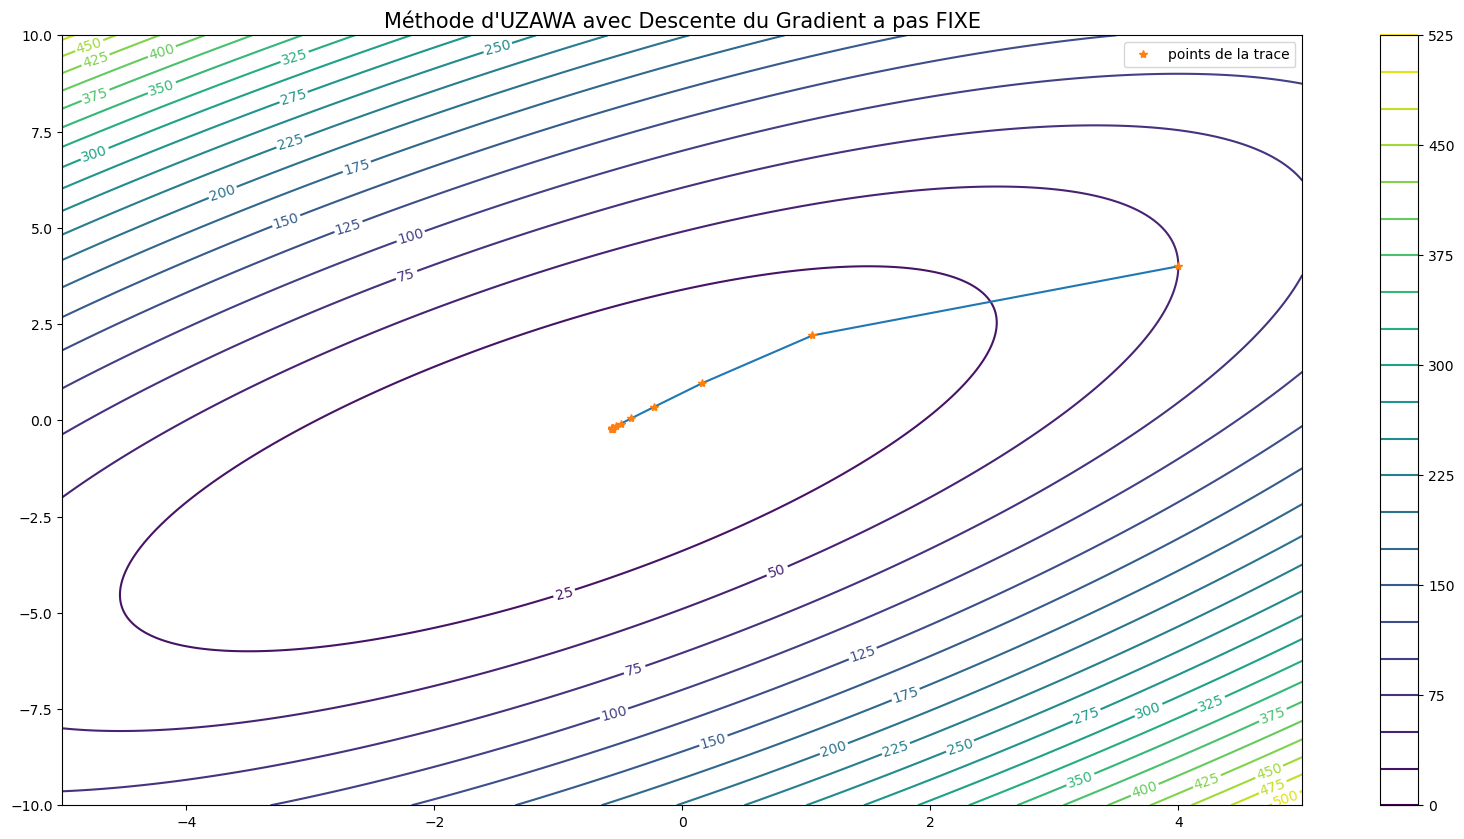

In [61]:
plot_trace(f, trace_X , "Méthode d'UZAWA avec Descente du Gradient a pas FIXE")

#### 2.Critère d'arrêt : Test des incréments

In [64]:
X, trace_X, lambda_n, trace_lambda  = fit_uzawa_methode(f , gradient_f , g, gradient_g , X_0 , np.array([1, 1]) , PAS_FIXE, PAS_FIXE, None,epsilon=.0001)

> UZAWA : Finished in 977 iterations


##### Historique des valeurs

In [65]:
print(*[f"X={X} , f(X)={f(X[0], X[1])}" for X in trace_X[:15]], sep="\n")
print(".\n.\n.")
print(f"X={trace_X[-1]} , f(X)={f(trace_X[-1][0], trace_X[-1][1])}")

X=[4. 4.] , f(X)=50.0
X=[-0.59089447 -0.22724907] , f(X)=0.5992106295688913
X=[-0.58994801 -0.22694864] , f(X)=0.5998223582205207
X=[-0.58897819 -0.22660601] , f(X)=0.6005050460415158
X=[-0.58801339 -0.22626712] , f(X)=0.6011866566045212
X=[-0.58705454 -0.22593348] , f(X)=0.6018647401086039
X=[-0.58610053 -0.22560337] , f(X)=0.602541943868802
X=[-0.58515182 -0.22527752] , f(X)=0.6032170412910649
X=[-0.58420889 -0.22495675] , f(X)=0.603888695144859
X=[-0.58327064 -0.22463931] , f(X)=0.604559583044241
X=[-0.5823375  -0.22432594] , f(X)=0.6052284803774686
X=[-0.58140998 -0.22401745] , f(X)=0.6058940475299506
X=[-0.58048696 -0.22371212] , f(X)=0.6065589573866974
X=[-0.57956891 -0.22341067] , f(X)=0.6072219851267868
X=[-0.57865629 -0.22311393] , f(X)=0.6078817875822353
.
.
.
X=[-0.32629292 -0.13212649] , f(X)=0.983163666910112


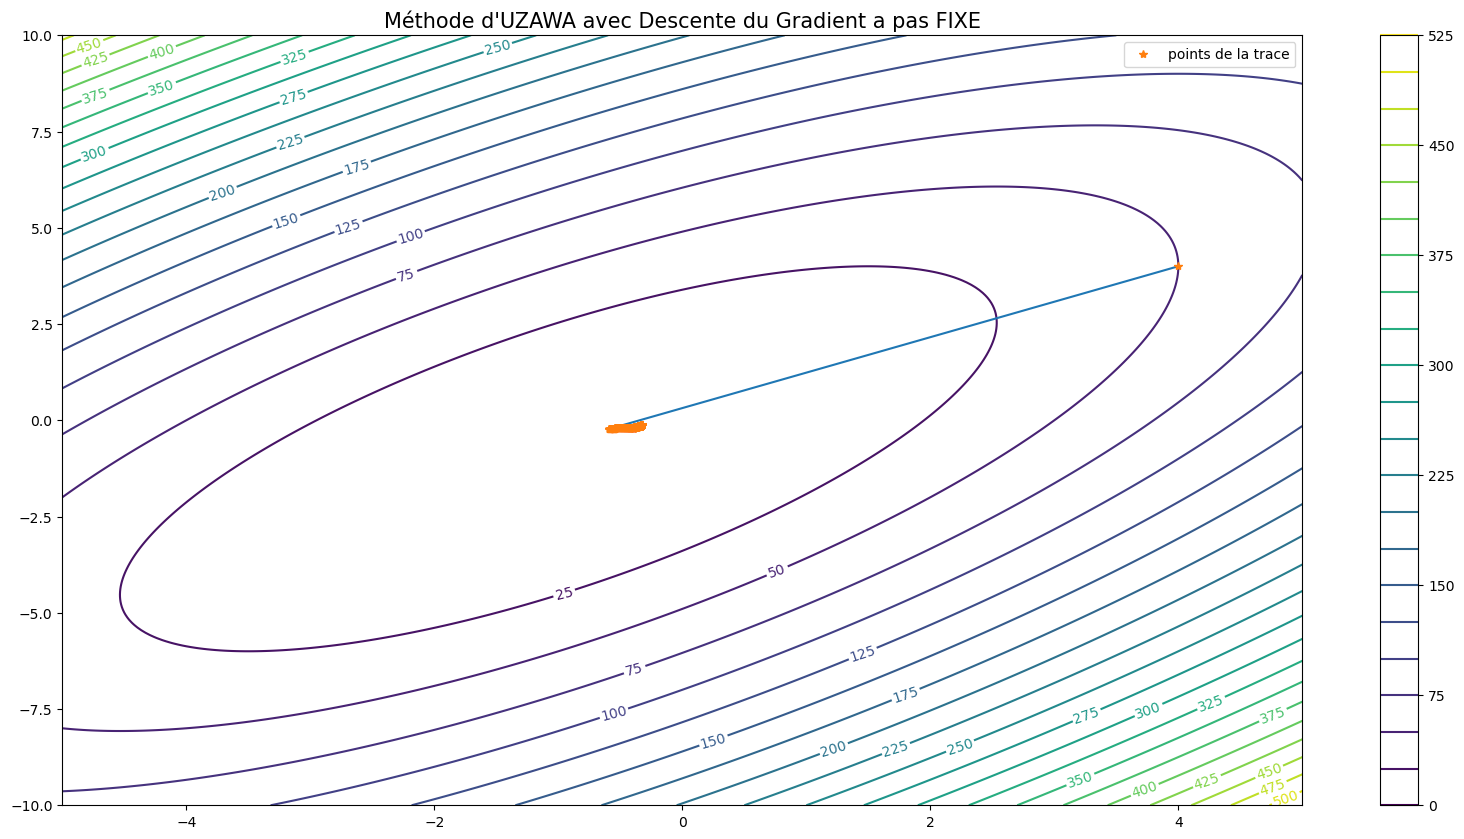

In [66]:
plot_trace(f, trace_X , "Méthode d'UZAWA avec Descente du Gradient a pas FIXE")

### Second test 

**A poorly conditioned quadratic function** :

$$f(x,y) = \frac{1}{2} x^2 + 100y^2 $$

$$ \nabla f(x,y) = \begin{bmatrix} x  \\ 200y \end{bmatrix} $$

$$\nabla^2 f(x, y) = \begin{bmatrix} 1 & 0 \\ 0 & 200 \end{bmatrix} $$

$$ ( \nabla^2 f(x, y) )^{-1} = \begin{bmatrix} 1 & 0 \\ 0 & \frac{1}{200} \end{bmatrix} $$

In [67]:
def f(x, y):
    return 1/2 * x**2 + 100 * y**2


def gradient_f(X):
    return np.array([X[0], 200*X[1]])


def hessiene_f(X):
    return np.array([[1, 0], [0, 200]])


def hessien_inv(X):
    return np.array([[1, 0], [0, 1/200]])

Having conducted tests with different step values, we observed that, for a FIXED_STEP of 0.00001, the Uzawa method converges towards the solution

In [68]:
PAS_FIXE = 0.00001
X, trace_X, lambda_n, trace_lambda = fit_uzawa_methode(
    f, gradient_f, g, gradient_g, X_0, np.array([1, 1]), PAS_FIXE, PAS_FIXE, 300, None)

> UZAWA : Finished in 300 iterations


##### Historique des valeurs

In [69]:
print(*[f"X={X} , f(X)={f(X[0], X[1])}" for X in trace_X[:15]], sep="\n")
print(f"X={trace_X[-1]} , f(X)={f(trace_X[-1][0], trace_X[-1][1])}")

X=[4. 4.] , f(X)=1608.0
X=[3.96117439 2.18302904] , f(X)=484.40702894625747
X=[3.92269179 1.19242525] , f(X)=149.88155373076978
X=[3.88455002 0.6523537 ] , f(X)=50.10139983756309
X=[3.8467464  0.35791013] , f(X)=20.20869497117662
X=[3.80927809 0.19738156] , f(X)=11.151247765109565
X=[3.77214224 0.10986263] , f(X)=8.321508221187685
X=[3.735336   0.06214806] , f(X)=7.362605682067566
X=[3.69885653 0.03613456] , f(X)=6.971340428272961
X=[3.66270103 0.0219523 ] , f(X)=6.755879763645041
X=[3.62686672 0.01422034] , f(X)=6.597302895481192
X=[3.59135082 0.01000503] , f(X)=6.458910404892038
X=[3.55615059 0.00770696] , f(X)=6.329043231140041
X=[3.52126331 0.00645415] , f(X)=6.203813261966561
X=[3.48668628 0.00577122] , f(X)=6.081821293989071
X=[-0.04497447  0.00496694] , f(X)=0.0034784013263127692


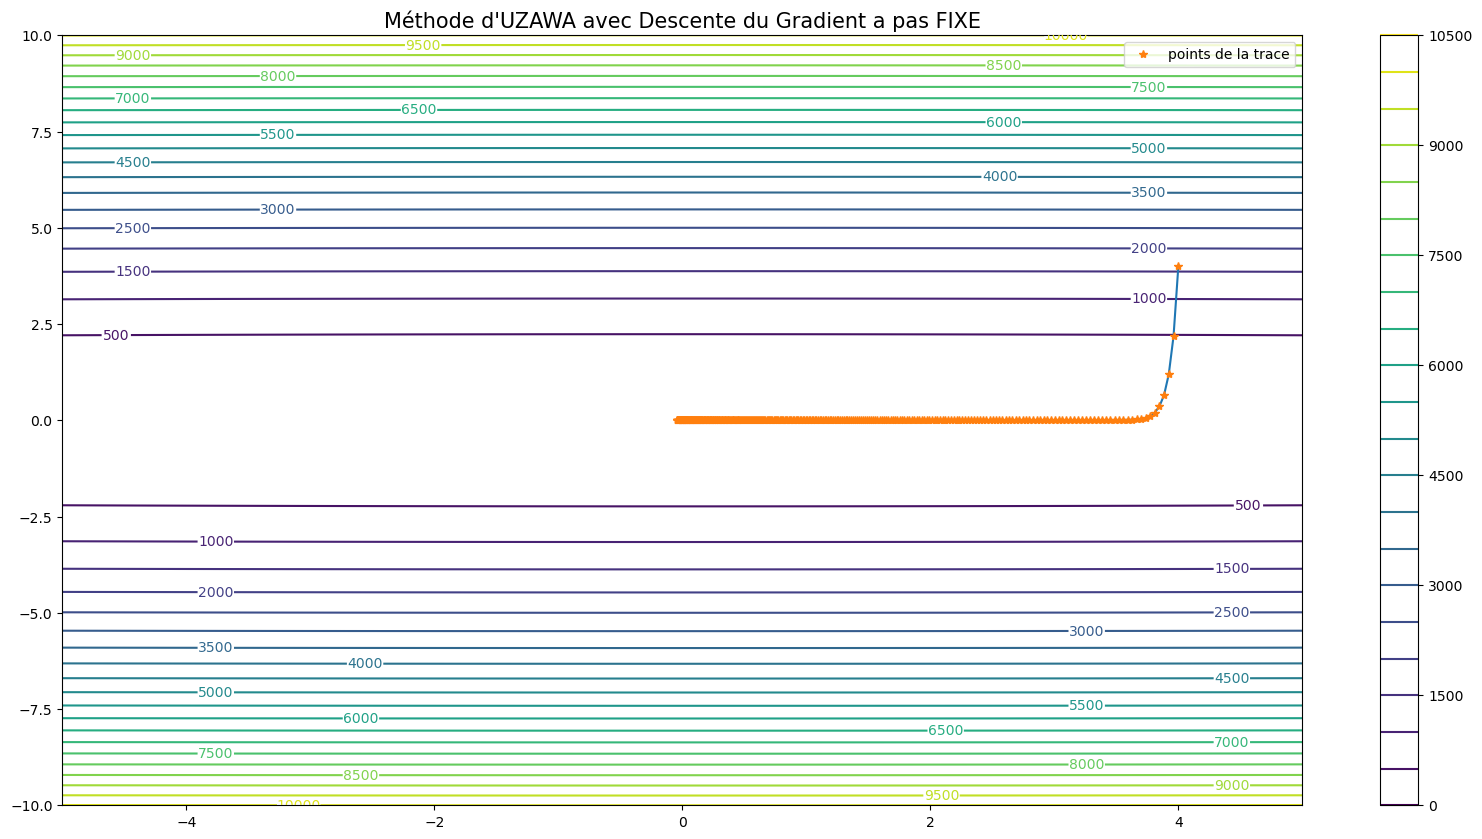

In [70]:
plot_trace(f, trace_X ,"Méthode d'UZAWA avec Descente du Gradient a pas FIXE")

#### Test de la methode d'UZAWA a pas variable

##### Linear decay method used by Keras

$$
\tau_n = \frac{\tau_0}{\alpha n + 1}
$$

An advanced technique involves using a variable step size, rather than a fixed step, to adjust weights more efficiently. This approach is particularly relevant when employing linear decay methods for the step size, as implemented in frameworks like Keras

In [ ]:
PAS_FIXE = .005

In [ ]:
X, trace_X, lambda_n, trace_lambda = fit_uzawa_methode(
    f, gradient_f, g, gradient_g, X_0, np.array([1, 1]), PAS_FIXE, PAS_FIXE, 100, None , adaptif=True)

> UZAWA : Finished in 100 iterations


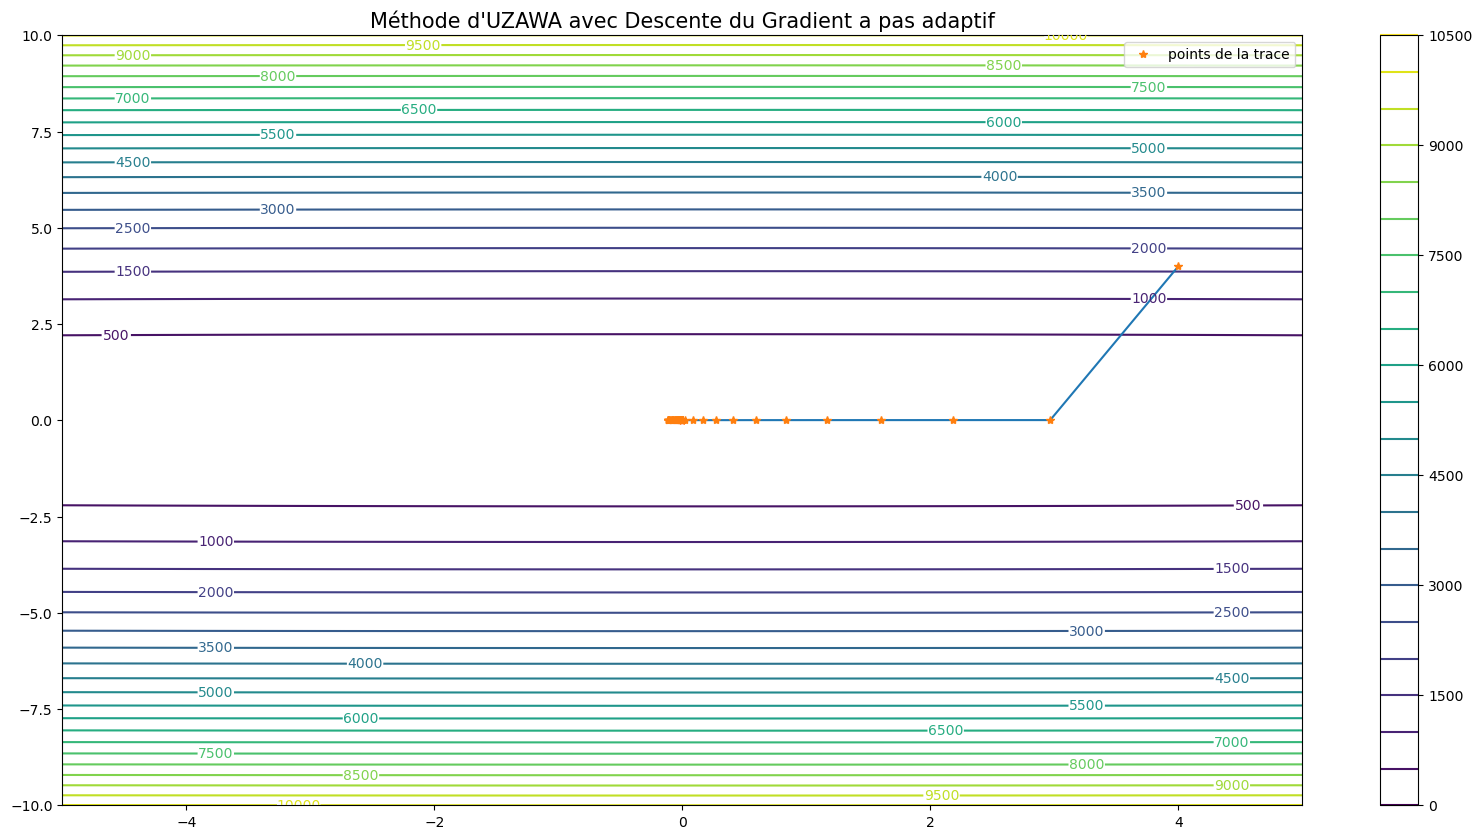

In [ ]:
plot_trace(f, trace_X , "Méthode d'UZAWA avec Descente du Gradient a pas adaptif")

## Conclusion

In conclusion, when using the Uzawa method for poorly conditioned optimization problems, it is crucial to carefully choose the initial point and the learning rate. A well-chosen initial point can enhance the algorithm's convergence, while an appropriate learning rate helps avoid instability and oscillations, ensuring effective progress toward the solution. These choices are critical for the success and efficiency of the Uzawa method in solving complex optimization problems